In [9]:
import os
import bson
import gzip
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, misc

from GF_data_tools.fetch_data import run_query
from GF_data_tools.wave_utils.new_wave import TimeWave

In [10]:
AURORA_MOUNT = os.getenv('AURORA_MOUNT')
EXPERIMENT = 'pi3b'
MANIFEST = '2022_08_18'
CURRENT_LAYER = 'rogowski_combined/gapless'
VOLTAGE_LAYER = 'electrode_voltage/formation/scaled'

In [125]:
def plot_shot_current_and_voltage(shot : int):
    v_result = run_query({'manifest': MANIFEST,
                        'experiment': EXPERIMENT,
                        'shot': shot,
                        'layers': VOLTAGE_LAYER,
                        'nodisplay': True})
    v_wave = v_result['waves'][0]
    plt.figure(figsize = (10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(v_wave.x_axis(), v_wave)
    print(min(v_wave.x_axis()))
    plt.ylabel(v_wave.units)
    plt.title(shot)

    i_result = run_query({'manifest': MANIFEST,
                        'experiment': EXPERIMENT,
                        'shot': shot,
                        'layers': CURRENT_LAYER,
                        'nodisplay': True})
    i_wave = i_result['waves'][0]
    plt.subplot(1, 2, 2)
    plt.plot(i_wave.x_axis(), i_wave / 1000)
    print(min(i_wave.x_axis()))
    plt.ylabel('k' + i_wave.units)

View no plasma shots

-0.00136
-0.00116
-0.00134
-0.00114
-0.00136
-0.00116
-0.00133
-0.00113
-0.00159
-0.00109
-0.00133
-0.00113
-0.00132
-0.00112
-0.00136
-0.00116


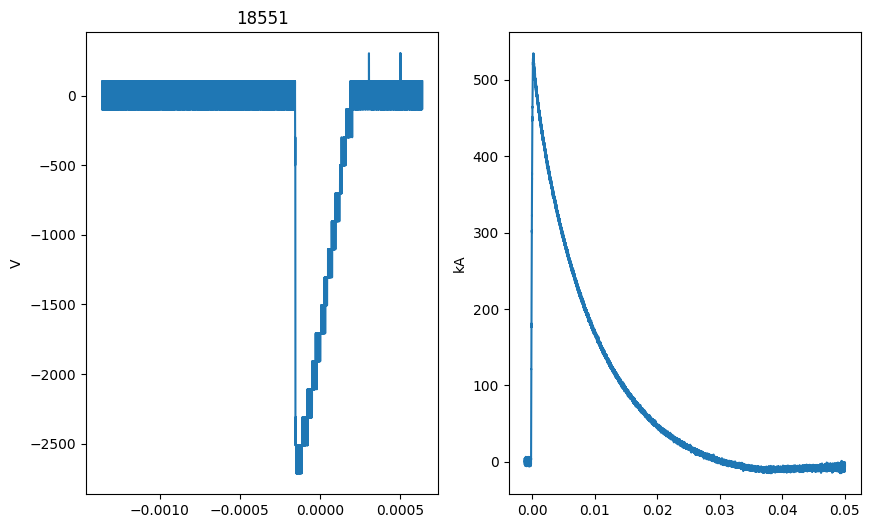

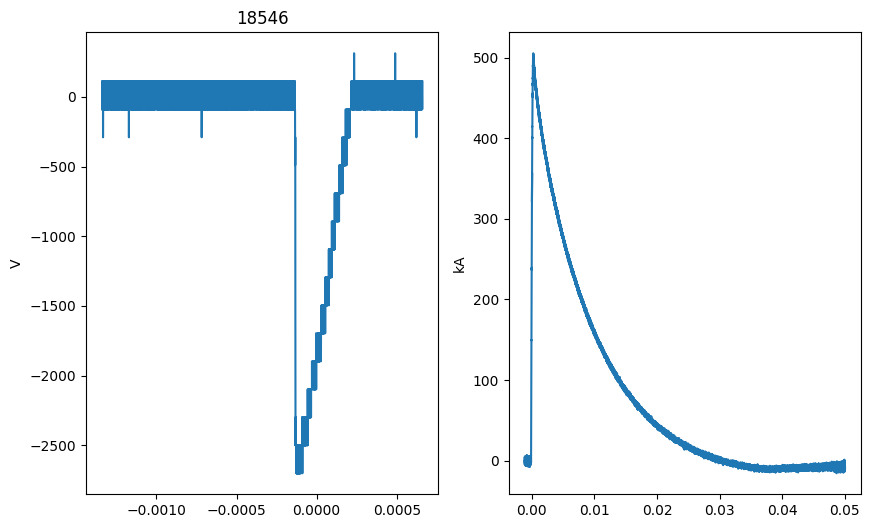

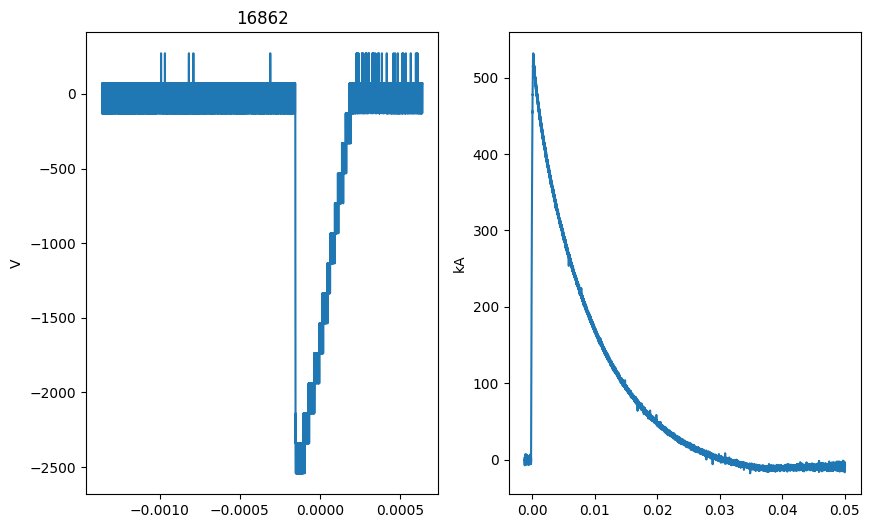

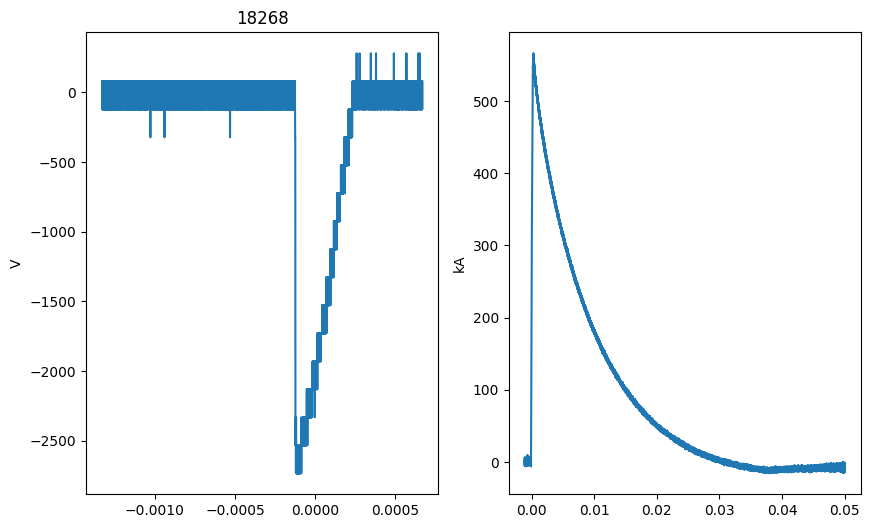

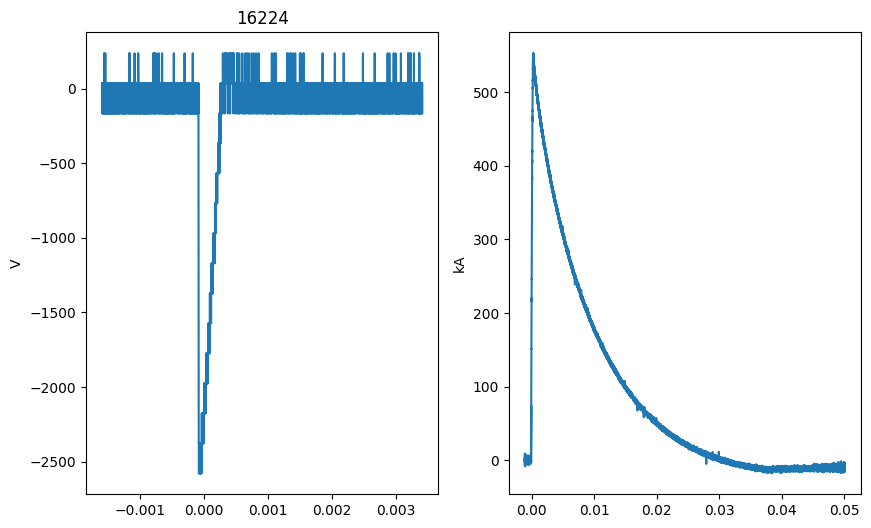

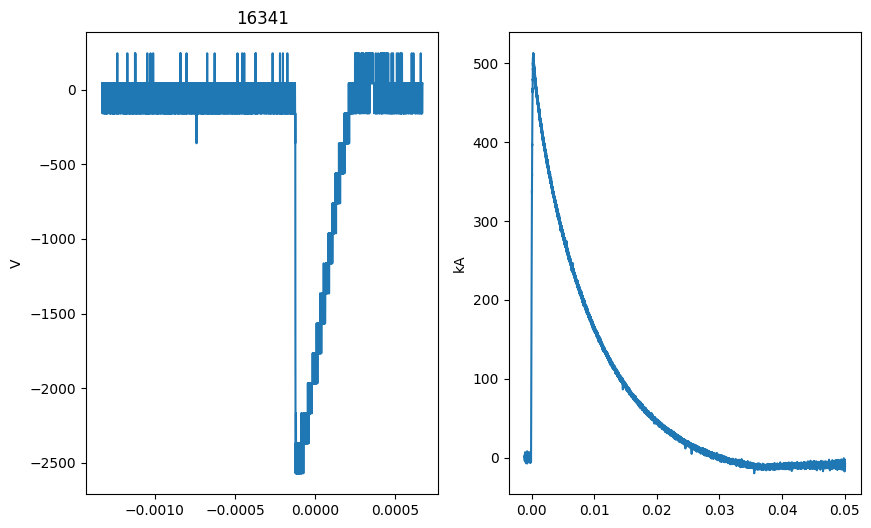

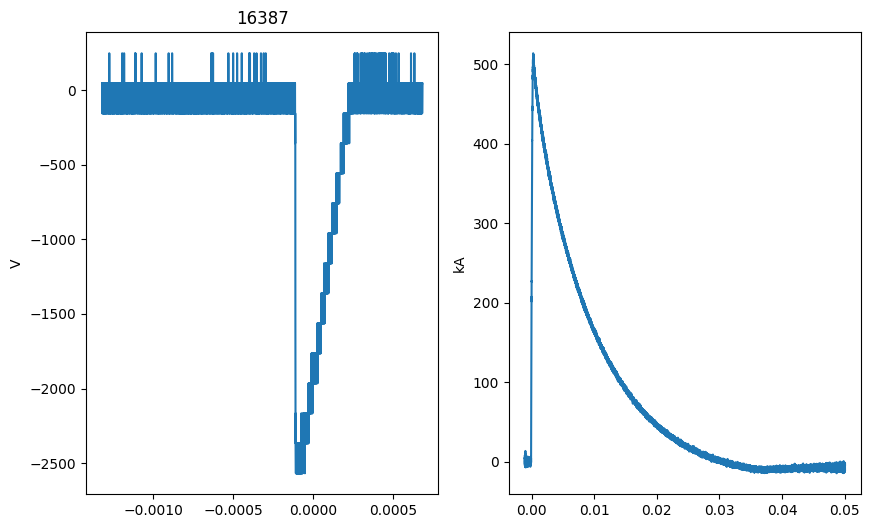

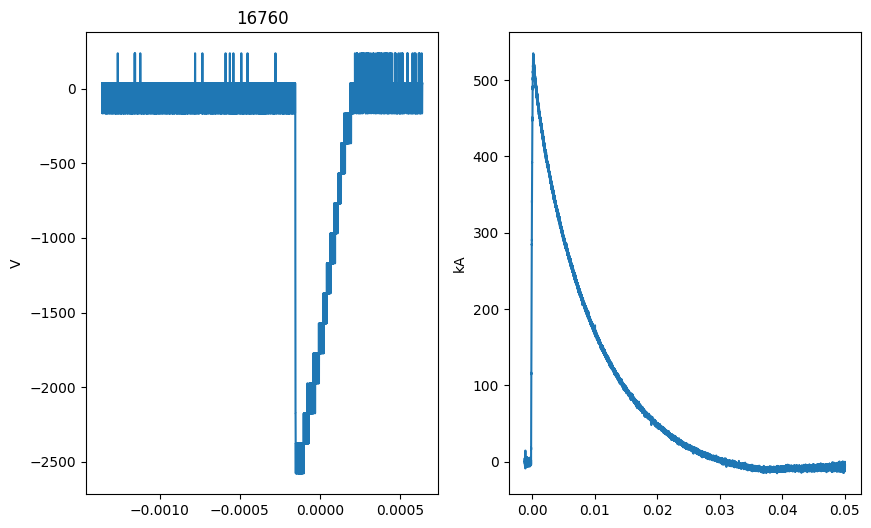

In [126]:
no_plasma_shots = [18551, 18546, 16862, 18268, 16224, 16341, 16387, 16760]

for no_plasma_shot in no_plasma_shots:
    plot_shot_current_and_voltage(no_plasma_shot)


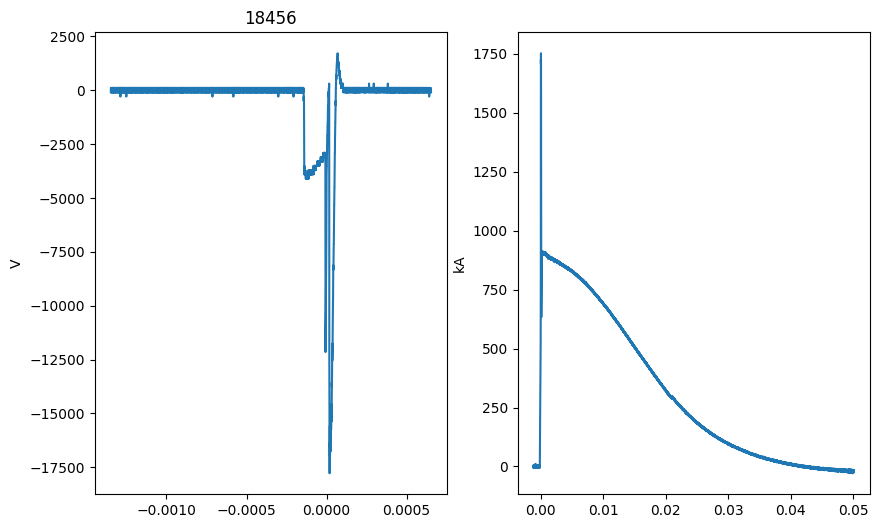

In [116]:
plot_shot_current_and_voltage(18456)

In [114]:
def plot_wave_at_layer(shot : int, layer : str):
    result = run_query({'manifest': MANIFEST,
                        'experiment': EXPERIMENT,
                        'shot': shot,
                        'layers': layer,
                        'nodisplay': True})
    wave = result['waves'][0]
    plt.plot(wave.x_axis(), wave)
    plt.ylabel(wave.units)
    print(wave.units)
    plt.title(shot)

##### Get L and R profiles using shots with no plasma ($\phi_{plasma} = 0$)

In [15]:
def get_interpolated_wave_function(shot : int, layer_name : str):
    result = run_query({'manifest': MANIFEST,
                        'experiment': EXPERIMENT,
                        'shot': shot,
                        'layers': layer_name,
                        'nodisplay': True})
    wave = result['waves'][0]
    if 'voltage' in layer_name:
        voltage_xs = wave.x_axis().tolist()
        voltage_xs.append(.05006)
        voltage_ys = wave.tolist()
        voltage_ys.append(0)
        return interpolate.interp1d(voltage_xs, voltage_ys)
    else:
        return interpolate.interp1d(wave.x_axis(), wave)

In [128]:
Is = [get_interpolated_wave_function(shot, CURRENT_LAYER) for shot in no_plasma_shots]
Vs = [get_interpolated_wave_function(shot, VOLTAGE_LAYER) for shot in no_plasma_shots]

In [127]:
def current_dot_f(current_f, t):
    return misc.derivative(current_f, t, dx=1e-4)

$$\phi_{total} = \phi_{wall} + \phi_{plasma}$$
$$\phi_{wall} = LI$$
$$\dot{\phi}_{total} = \dot{L}I + L\dot{I} + \dot{\phi}_{plasma}= -(V - IR)$$
but for shots with no plasma, $\phi_{plasma} = \dot{\phi}_{plasma} = 0$, so 
$$\dot{\phi}_{total} = \dot{L}I + L\dot{I} = -(V - IR) \implies$$
$$\frac{L_0}{\tau}e^{\frac{-t}{\tau}}I(t) + (L_f  - L_0e^{\frac{-t}{\tau}})\dot{I}(t) = -V(t) + I(t)(R_f + R_0e^{\frac{-t}{\tau}})$$

In [140]:
t = np.linspace(0, .001, 10)
print(t)

t_val = .0003
t_index = np.argwhere(np.array(t)>t_val)[0][0]
print(t_index)

[0.         0.00011111 0.00022222 0.00033333 0.00044444 0.00055556
 0.00066667 0.00077778 0.00088889 0.001     ]
3


In [159]:
import numpy as np
import math
from scipy.optimize import leastsq

def to_fit(ts : list, I, V, I_dot, L_0, L_f, R_0, R_f, tau):
  return [(L_0 / tau)*math.exp(-t/tau)*I(t) + (L_f - L_0*math.exp(-t/tau))*I_dot(t) + V(t) - I(t)*(R_f + R_0*math.exp(-t/tau)) for t in ts]

def leastsq_func(params, *args):
  t = args[0] # Size 1xn where n = # t values
  Is = args[1] # Size m*n where m is number of curves
  Vs = args[2] # m*n
  
  num_curves = len(Is)
  num_ts = len(t)

  L_0, L_f, R_0, R_f, tau = params

  yfit = np.empty(num_curves * num_ts)

  for curve_index in range(num_curves):
    start = curve_index * num_ts
    end = start + num_ts

    if L_0 <= 0 or L_f <= 0 or R_0 <= 0 or R_f <= 0 or tau <= 0: # all must be positive
      yfit[start:end] = [1e12]*num_ts
    elif L_0 > L_f or R_0 > R_f: # L or R does not change by large amount
      yfit[start:end] = [1e12]*num_ts 
    else:
      I_dot = lambda t : current_dot_f(Is[curve_index], t)
      yfit[start:end] = to_fit(t, Is[curve_index], Vs[curve_index], I_dot, L_0, L_f, R_0, R_f, tau) # minimize this 

  return yfit

In [160]:
ts = np.linspace(-0.0005, .045, 1000)

# params = [1e-2, 1e-2, 1e-2, 1e-2, 1e-3] # [8.99815601e-03 7.01967411e-03 3.05580962e+00 1.79716294e-09 1.35646624e-03]
params = [1e-5, 1e-5, 1e-5, 1e-5, 1e-3] # -7.71400531e-07  3.05390662e-07 -1.34440246e-03  1.30417891e-03  2.32039069e-02

args = tuple([ts, [Is[0]], [Vs[0]]])

result = leastsq(leastsq_func, params, args=args, xtol = 1e-15, maxfev=2000)
# for var, val in zip(['L_0', 'L_f', 'R_0', 'R_f', 'tau'], result[0]):
#     print(f'{var}: {val}')
L_0, L_f, R_0, R_f, tau = result[0]
print(result[0])

[9.72067456e-07 2.05934686e-06 1.42732780e-10 2.42696064e-04
 4.42504855e-03]


In [147]:
def L(L_0, L_f, tau, t):
    return L_f - L_0*math.exp(-t/tau)

def R(R_0, R_f, tau, t):
    return R_f + R_0*math.exp(-t/tau)

Text(0.5, 1.0, 'R')

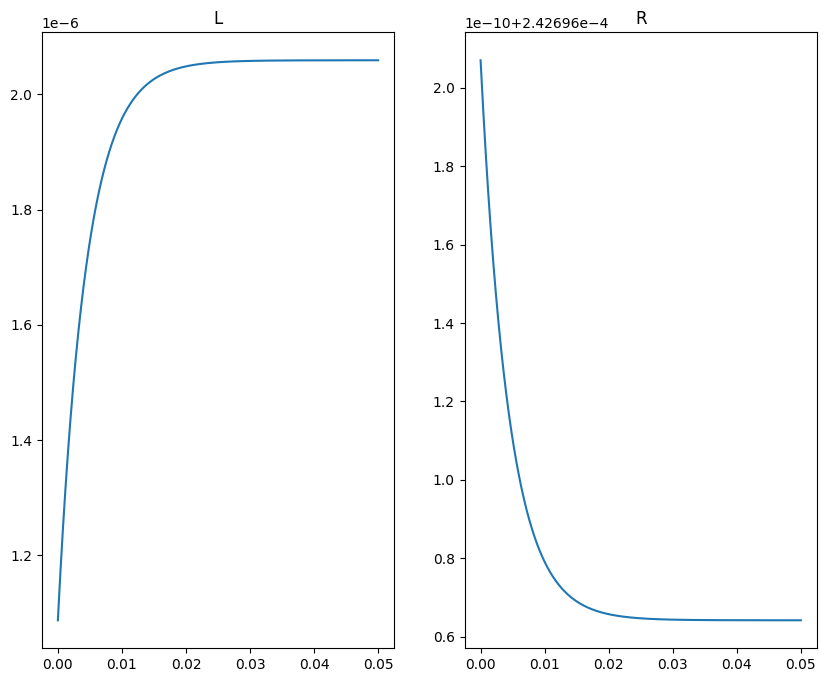

In [161]:
ts = np.linspace(0,.05, 1000)

plt.figure(figsize=(10, 8))
Rs = [R(R_0, R_f, tau, t) for t in ts]
Ls = [L(L_0, L_f, tau, t) for t in ts]

plt.subplot(1, 2, 1)
plt.plot(ts, Ls)
plt.title('L')
plt.subplot(1, 2, 2)
plt.plot(ts, Rs)
plt.title('R')

$$\phi_{wall} = LI$$

In [27]:
def get_phi_wall(shot : int, L_fxn):
    current_f = get_interpolated_wave_function(shot, CURRENT_LAYER)
    return lambda t : current_f(t) * L_fxn(t)

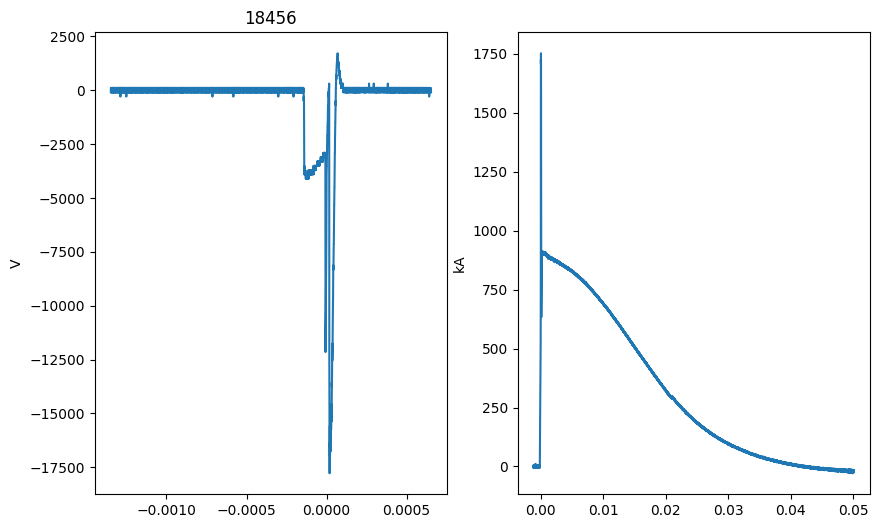

In [94]:
shot = 18456
plot_shot_current_and_voltage(shot)

In [29]:
L_fxn = lambda t : L(L_0, L_f, tau, t)
phi_wall_fxn = get_phi_wall(shot, L_fxn)

$$\phi_{total} = -\int{(V - IR)dt }$$

In [70]:
from scipy import integrate

def get_phi_total_fxn(V_fxn, I_fxn, R_fxn, input_upper_bound : bool):
    integrand = lambda t : V_fxn(t) - I_fxn(t) * R_fxn(t)
    if input_upper_bound:
        return lambda t : -1*integrate.quad(integrand, 0.005, t, limit=1000000)
    else:
        return lambda t : -1*integrate.quad(integrand, t, 0.045, limit=1000000)

In [71]:
I_fxn = get_interpolated_wave_function(shot, CURRENT_LAYER)
V_fxn = get_interpolated_wave_function(shot, VOLTAGE_LAYER)
R_fxn = lambda t : R(R_0, R_f, tau, t)

phi_total_insert_lower_bound_fxn = get_phi_total_fxn(V_fxn, I_fxn, R_fxn, False)
phi_total_insert_upper_bound_fxn = get_phi_total_fxn(V_fxn, I_fxn, R_fxn, True)

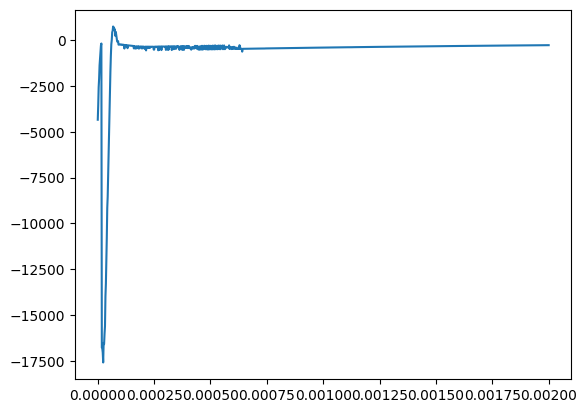

In [80]:
integrand = lambda t : V_fxn(t) - I_fxn(t) * R_fxn(t)
# ts = np.linspace(0,.001, 10000)
ts = np.linspace(0, 0.002, 1000)

ys = [integrand(t) for t in ts]

plt.plot(ts, ys)


In [72]:
phi_total_insert_lower_bound_fxn(.02)

()

In [73]:
phi_total_insert_upper_bound_fxn(.02)

/home/brendan.posehn@gf.local/ramdisk/ipykernel_1807247/2318334337.py:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return lambda t : -1*integrate.quad(integrand, 0.005, t, limit=1000000)


()

In [47]:
def get_i_fxn():
    f = lambda x : x**2
    return lambda x : integrate.quad(f, 0, x)

i_fxn = get_i_fxn()
i_fxn(2)


(2.666666666666667, 2.960594732333751e-14)

$$\phi_{plasma} = \phi_{total} - \phi_{wall}$$

$$ L = $$